In [1]:
%matplotlib inline
import fitsio
import healpy as hp
from lusee.mono_sky_models import T_DarkAges
import matplotlib.pyplot as plt
from maxsmooth.DCF import smooth
import numpy as np 

In [2]:
sky = fitsio.read("../simulation/SkyModels/ULSA_32_ddi_smooth.fits")
nside = 32
freq = np.arange(1, 51, 1)

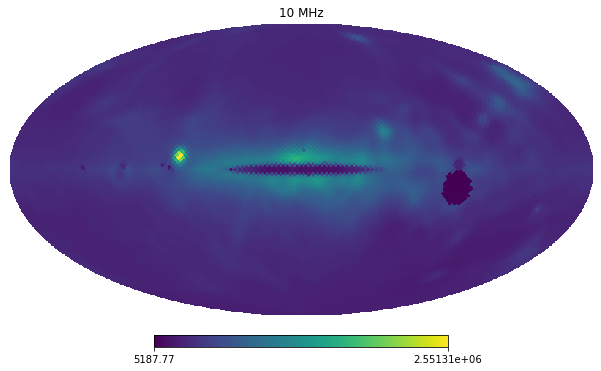

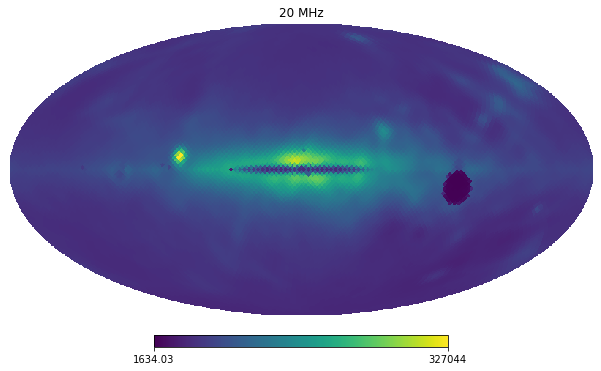

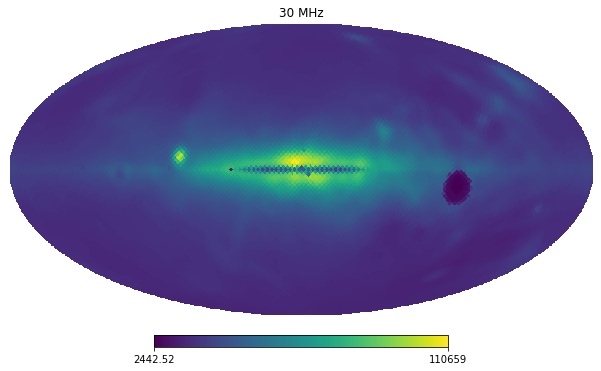

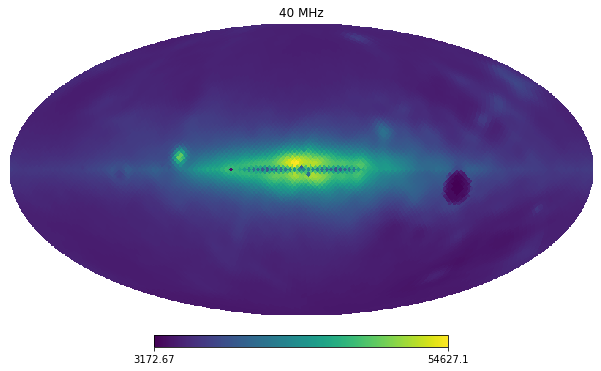

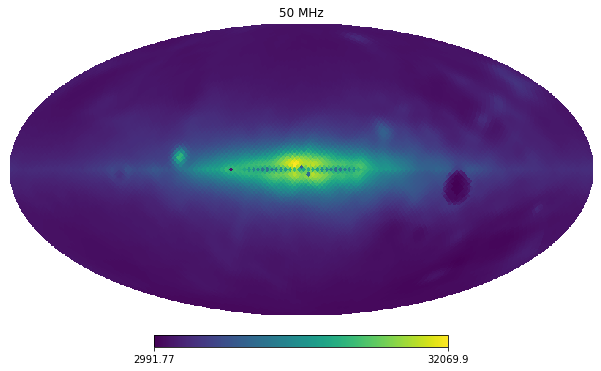

In [3]:
f_plot = [10, 20, 30, 40, 50]
for f in f_plot:
    hp.mollview(sky[f-1], title=f"{f} MHz")

# SVD and covariance matrices

Let the sky be described by $\mathbf{X}$ which is a matrix of shape $N_{\rm freq} \times N{\rm pix}$.
Without subtracting the mean, the covariance matrix is given by:
$$\mathbf{C} \equiv \mathbf{X} \mathbf{X}^T$$

Computing SVD of the sky transposed (if you don't transpose the sky then U and V switch roles):
$$\mathbf{X}^T = \mathbf{U}\mathbf{\Sigma}\mathbf{V}^T$$

In the above equation, $\mathbf{U}$ and $\mathbf{V}$ are orthogonal so $\mathbf{U}^{-1} = \mathbf{U}^T$ and $\mathbf{V}^{-1} = \mathbf{V}^T$. Moreover, $\mathbf{\Sigma}$ is diagonal so $\mathbf{\Sigma} = \mathbf{\Sigma}^T$.

Thus, the covariance matrix is:

$$\mathbf{C} = \mathbf{X} \mathbf{X}^T = \left(\mathbf{U}\mathbf{\Sigma}\mathbf{V}^T\right)^T \mathbf{U}\mathbf{\Sigma}\mathbf{V}^T = \mathbf{V} \mathbf{\Sigma}^T \mathbf{U}^T \mathbf{U}\mathbf{\Sigma}\mathbf{V}^T = \mathbf{V} \mathbf{\Sigma}^2 \mathbf{V}^T$$

Thus, the SVD (let's say it's $\mathbf{C} = \mathbf{U_c} \mathbf{\Sigma_c} \mathbf{V_c}^T$) of the covariance matrix $\mathbf{C}$ is related to the covariance of the sky by $\mathbf{U_c} = \mathbf{V}$, $\mathbf{\Sigma_c} = \mathbf{\Sigma}^2$, $\mathbf{V_c} = \mathbf{V}$ up to factors of $\pm 1$.

In [4]:
U, S, V_t = np.linalg.svd(sky.T)  # sky
Uc, Sc, Vc_t = np.linalg.svd(sky @ sky.T)  # covariance of sky (not mean subtracted)
Ucc, Scc, Vcc_t = np.linalg.svd(np.cov(sky))  # mean subtracted

In [5]:
npix = sky.shape[-1]

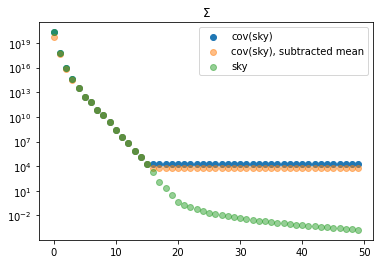

In [6]:
plt.figure()
plt.scatter(np.arange(S.size), Sc, label="cov(sky)")
plt.scatter(np.arange(S.size), Scc *(npix-1) , alpha=0.5, label="cov(sky), subtracted mean")  # squared
plt.scatter(np.arange(S.size), S**2, alpha=0.5, label="sky")  # squared
plt.yscale("log")
plt.title("$\\Sigma$")
plt.legend()
plt.show()

In [7]:
print(np.allclose(np.abs(V_t)[:12], np.abs(Vc_t)[:12], rtol=1e-4))

True


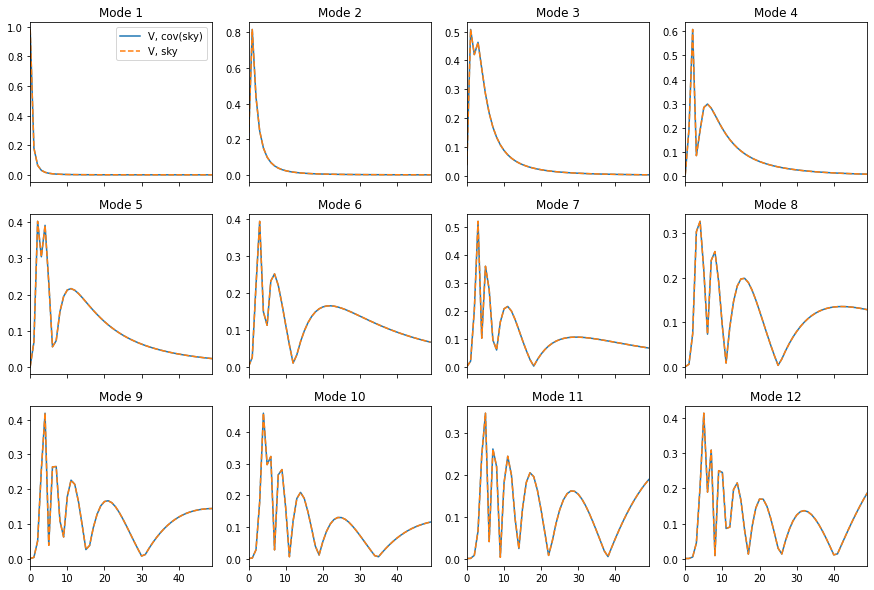

In [8]:
fig, axs = plt.subplots(figsize=(15,10), nrows=3, ncols=4, sharex=True)
for i in range(12):
    plt.sca(axs.ravel()[i])
    plt.plot(np.abs(Vc_t)[i], label="V, cov(sky)")
    plt.plot(np.abs(V_t)[i], ls="--", label="V, sky")
    plt.xlim(0, 49)
    plt.title(f"Mode {i+1}")
axs[0,0].legend()
plt.show()

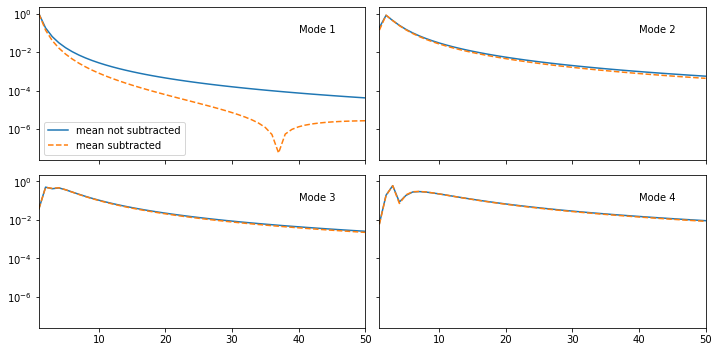

In [9]:
fig, axs = plt.subplots(figsize=(10,5), ncols=2, nrows=2, sharey=True, sharex=True)
for i in range(4):
    plt.sca(axs.ravel()[i])
    plt.plot(freq, np.abs(Vc_t[i]), label="mean not subtracted")
    plt.plot(freq, np.abs(Vcc_t[i]), ls="--", label="mean subtracted")
    plt.yscale("log")
    plt.text(40, 1e-1, f"Mode {i+1}")
axs[0, 0].legend(loc = "lower left")
plt.tight_layout()
plt.xlim(freq.min(), freq.max())
plt.show()

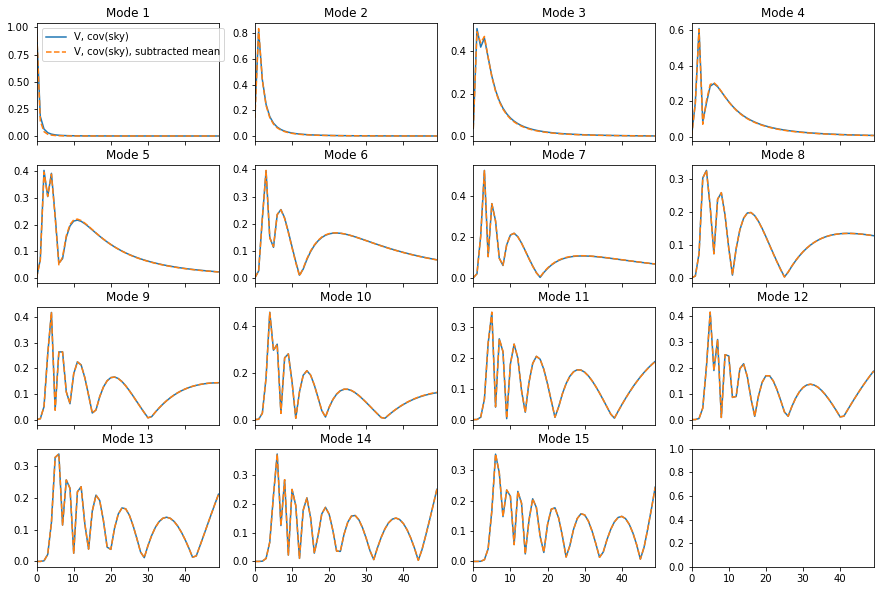

In [10]:
fig, axs = plt.subplots(figsize=(15,10), nrows=4, ncols=4, sharex=True)
for i in range(15):
    plt.sca(axs.ravel()[i])
    plt.plot(np.abs(Vc_t)[i], label="V, cov(sky)")
    plt.plot(np.abs(Vcc_t)[i], ls="--", label="V, cov(sky), subtracted mean")
    plt.xlim(0, 49)
    plt.title(f"Mode {i+1}")
axs[0,0].legend()
plt.show()

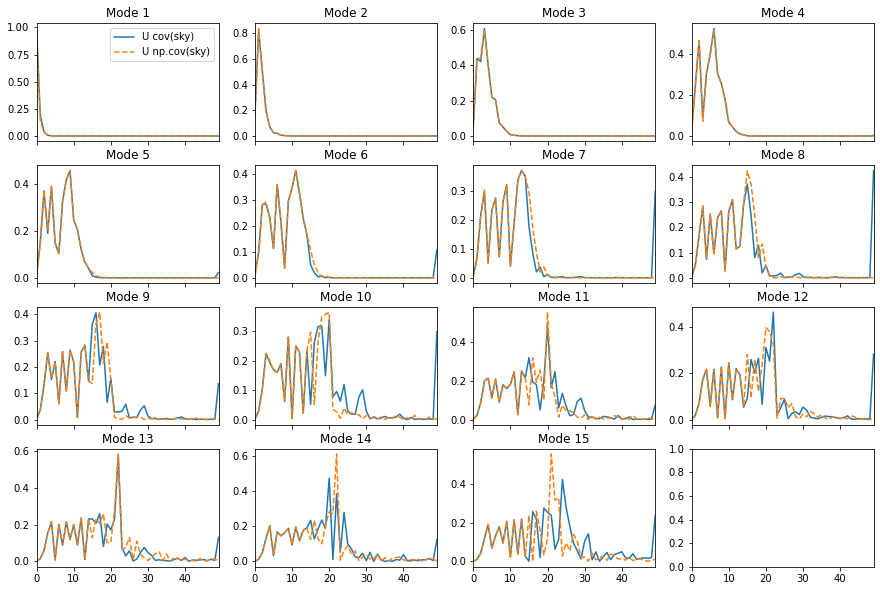

In [11]:
# mostly the same but something funky going on at large modes and frequencies
# probably because U is pretty small and normalization messes it up
fig, axs = plt.subplots(figsize=(15,10), nrows=4, ncols=4, sharex=True)
for i in range(15):
    plt.sca(axs.ravel()[i])
    plt.plot(np.abs(Uc)[i], label="U cov(sky)")
    plt.plot(np.abs(Ucc)[i], ls="--", label="U np.cov(sky)")
    plt.xlim(0, 49)
    plt.title(f"Mode {i+1}")
axs[0,0].legend()
plt.show()

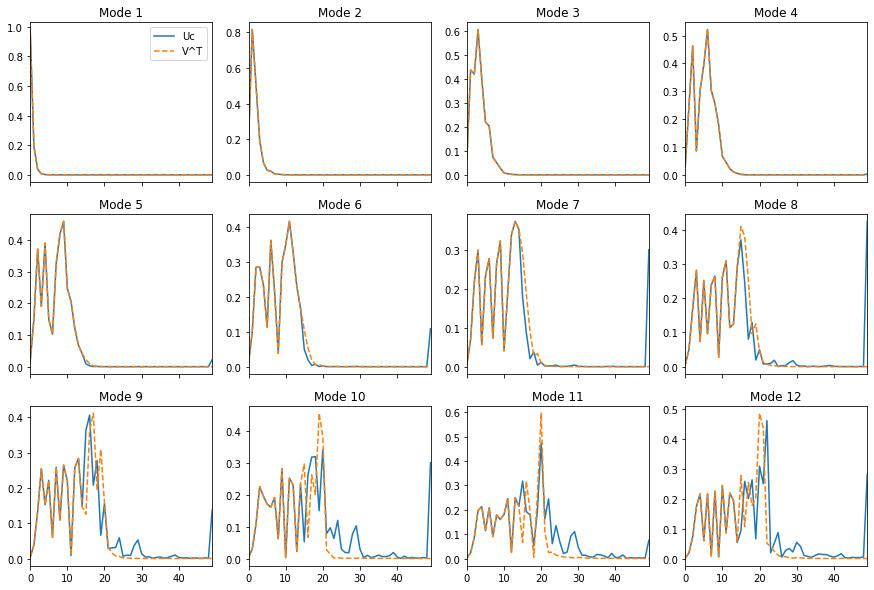

In [12]:
# mostly the same but something funky going on at large modes and frequencies
fig, axs = plt.subplots(figsize=(15,10), nrows=3, ncols=4, sharex=True)
for i in range(12):
    plt.sca(axs.ravel()[i])
    plt.plot(np.abs(Uc)[i], label="Uc")
    plt.plot(np.abs(V_t.T)[i], ls="--", label="V^T")
    plt.xlim(0, 49)
    plt.title(f"Mode {i+1}")
axs[0,0].legend()
plt.show()

# Eigenmode Analysis

In [81]:
class EigenAnalysis:
    
    def __init__(
        self,
        fg_path="../simulation/SkyModels/ULSA_32_ddi_smooth.fits",
        freqs=None,
        weight=None,
        subtract_mean=False
    ):
        self.fg = fitsio.read(fg_path)
        nfreqs = self.fg.shape[0]
        if not freqs:
            freqs = np.linspace(1, 50, nfreqs)
        self.freqs = np.squeeze(freqs).reshape(-1)
        self.t21 = T_DarkAges(self.freqs)
        self.weight = weight
        self.subtract_mean = subtract_mean
        
    @property
    def npix(self):
        return self.fg.shape[1]
    
    @property
    def nside(self):
        return np.sqrt(self.npix / 12).astype(int)
        
    def degrade(self, nside_out=16):
        npix = 12 * nside_out ** 2
        new_fg = np.empty((self.freqs.size, npix))
        for i in range(self.freqs.size):
            new_fg[i] = hp.ud_grade(self.fg[i], nside_out)
        self.fg = new_fg
        
    def remove_gal(self, b_min):
        col_min = np.pi/2 - np.deg2rad(b_min)
        col_max = np.pi/2 + np.deg2rad(b_min)
        mask_pix = hp.query_strip(self.nside, col_min, col_max, inclusive=False)
        self.fg = np.delete(self.fg, mask_pix, axis=1)
        
                
    def fit_maxsmooth(self, N_terms=5, model_type="log_polynomial", plot=False):
        for pix in range(self.npix):
            res_fg = smooth(self.freqs, self.fg[:, pix], N_terms, model_type=model_type, print_output=False)
            self.fg[:, pix] -= res_fg.y_fit
        res_21 = smooth(self.freqs, -self.t21, N_terms, model_type=model_type, print_output=False)
        fit_21 = res_21.y_fit * (-1)
        self.t21 = self.t21 - fit_21

        if plot:
            fig, axs = plt.subplots(figsize=(10,10), nrows=2, ncols=2, sharex=True)
            axs[0, 0].plot(self.freqs, self.fg[:, -1]+res_fg.y_fit, label="foregrounds")
            axs[0, 0].plot(self.freqs, res_fg.y_fit, ls="--", label="fit")
            axs[0, 0].legend()
            axs[0, 0].set_yscale("log")
            axs[0, 1].plot(self.freqs, self.t21 + fit_21, label="21cm")
            axs[0, 1].plot(self.freqs, fit_21, label="fit")
            axs[0, 1].legend()
            axs[1, 0].plot(self.freqs, self.fg[:, -1])
            axs[1, 1].plot(self.freqs, self.t21)
            axs[0, 0].set_ylabel("temperature [K]")
            axs[1, 0].set_ylabel("residuals [K]")
            plt.setp(axs[1], xlabel="frequency [MHz]", xlim=(self.freqs.min(), self.freqs.max()))
            plt.show()
            
    def compute_evalsvecs(self):
        d = self.fg / self.w
        if self.subtract_mean:
            d -= d.mean(axis=1, keepdims=True)
        C = d @ d.T
#        C = np.cov(self.fg / self.w)  # this is with mean subtracted and dvided by npix-1       
        U, S, V = np.linalg.svd(C)
        return S, V
    
    @property
    def w(self):
        if self.weight == "mean":
            return self.fg.mean(axis=1, keepdims=True) / self.fg.mean()
        elif self.weight == "power law":
            return self.freqs.reshape(-1, 1) ** (-2.5) * self.fg.mean(axis=1)[0] / self.fg.mean()
        else:
            return np.ones((self.freqs.size, 1))
        
    @property
    def evals(self):
        return self.compute_evalsvecs()[0]
        
    @property
    def evecs(self):
        return self.compute_evalsvecs()[1]
        
    def plot_t21(self):
        plt.figure()
        plt.plot(self.freqs, self.t21)
        plt.xlabel("$\\nu$ [MHz]")
        plt.ylabel("$T_{21}$ [K]")
        plt.title("Global Signal")
        plt.xlim(0, freq.max())
        plt.show()
            
    def plot_evals(self, yscale="log", relative=False):
        eig_nr = np.arange(len(self.evals))
        plt.figure()
        if relative:
            plt.scatter(eig_nr, self.evals / self.evals[0])
        else:
            plt.scatter(eig_nr, self.evals)
        plt.yscale(yscale)
        plt.title("Eigenvalues")
        if relative:
            ylabel = "relative temperature"
        else:
            ylabel = "temperature [K]"
        plt.ylabel(ylabel)
        plt.show()
    
    def plot_evecs(self, n_vecs=3):
        plt.figure(figsize=(10,7))
        plt.plot(self.freqs, self.evecs[:n_vecs].T)
        plt.xlim(self.freqs.min(), self.freqs.max())
        plt.title("Eigenvectors")
        plt.xlabel("frequency [MHz]")
        plt.ylabel("temperature [K]")
        plt.grid()
        plt.ylim(-1,1)
        plt.show()
        
    @property
    def proj_sky(self):
        return self.evecs @ (self.fg / self.w).mean(axis=1)
    
    @property
    def proj_t21(self):
        return self.evecs @ (self.t21 / self.w[:,0])
    
    def plot_proj(self, ylim=(1e-8, 1e6)):
        eig_nr = np.arange(self.proj_sky.size)
        plt.figure()
        plt.plot(eig_nr, np.abs(self.proj_sky), label="Foregrounds")
        plt.plot(eig_nr, np.abs(self.proj_t21), label="21cm")
        plt.xlabel("Eigenmode Number")
        plt.ylabel("$T$ [K]")
        plt.title("Global Signal in Foreground Eigenmode Basis")
        plt.xlim(eig_nr.min(), eig_nr.max())
        plt.yscale("log")
        plt.ylim(*ylim)
        plt.legend()
        plt.grid()
        plt.show()
        
    def filter_modes(self, Nmodes):
        sky = self.proj_sky
        sky[:Nmodes] = 0
        rec_sky = (self.evecs.T @ sky) * self.w[:,0]
        t21 = self.proj_t21
        t21[:Nmodes] = 0
        rec_21 = (self.evecs.T @ t21) * self.w[:,0]
        return rec_sky, rec_21
    
    def plot_filtered(self, Nmodes, ylim=(-0.05, 0.01)):
        rec_sky, rec_21 = self.filter_modes(Nmodes)
        plt.figure()
        plt.plot(self.freqs, rec_sky, label="Foregrounds")
        plt.plot(self.freqs, rec_21, label="21cm")
        plt.plot(self.freqs, self.t21, label="Original 21cm")
        plt.xlabel("$\\nu$ [MHz]")
        plt.ylabel("T [K]")
        plt.title(f"Filtered {Nmodes} Modes")
        plt.legend()
        plt.ylim(*ylim)
        plt.grid()
        plt.show()

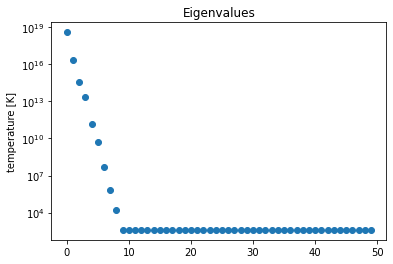

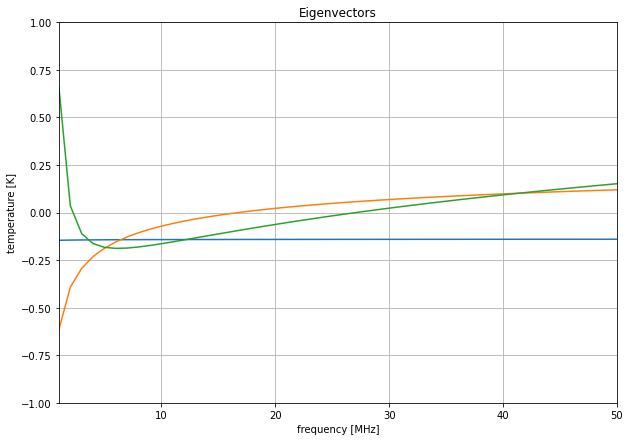

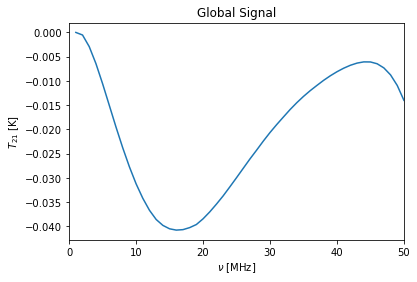

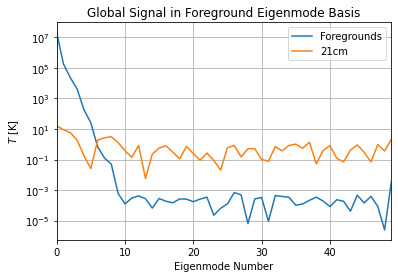

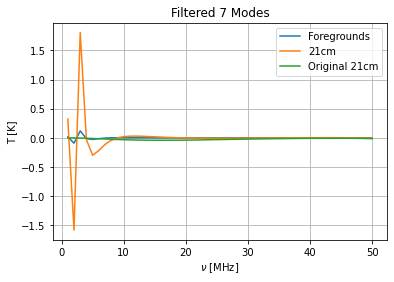

In [82]:
ea = EigenAnalysis(weight="mean", subtract_mean=False)
ea.remove_gal(20)
ea.plot_evals()
ea.plot_evecs(n_vecs=3)
ea.plot_t21()
ea.plot_proj(ylim=(None, None))
ea.plot_filtered(7, ylim=(None, None))

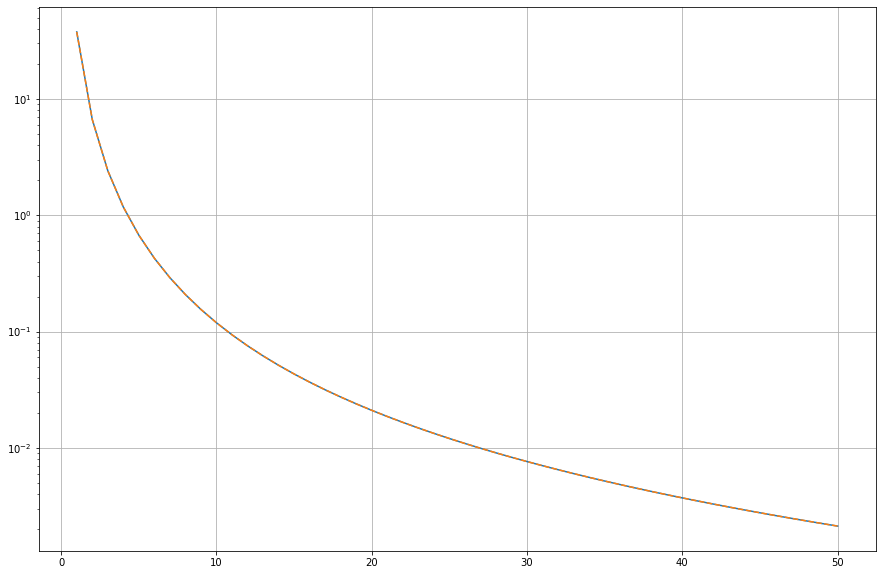

In [73]:
plt.figure(figsize=(15, 10))
plt.plot(ea.freqs, ea.w[:, 0], label="mean")
plt.plot(ea.freqs, ea.freqs**(-2.5) * ea.w[0,0], ls="--", label="power law")
plt.yscale("log")
plt.grid()
plt.show()

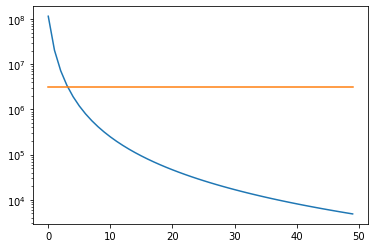

In [83]:
plt.figure()
plt.plot(ea.fg.mean(axis=1))
plt.plot(ea.fg.mean(axis=1) / ea.w[:,0])
plt.yscale("log")
plt.ylim(None)
plt.show()

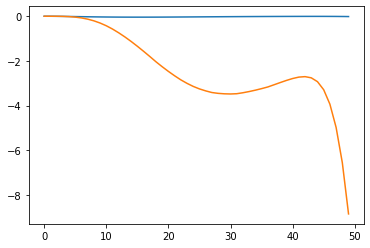

In [84]:
plt.figure()
plt.plot(ea.t21)
plt.plot(ea.t21 / ea.w[:,0])
#plt.yscale("log")
plt.ylim(None)
plt.show()

In [ ]:
ea8 = EigenAnalysis(weight=None, subtract_mean=False)
# # restrict freqs
# fcut = ea.freqs > 10
# ea.fg = ea.fg[fcut]
# ea.t21 = ea.t21[fcut]
# ea.freqs = ea.freqs[fcut]
# ###
ea8.degrade(1)
ea8.remove_gal(20)
ea8.plot_evecs(n_vecs=8)

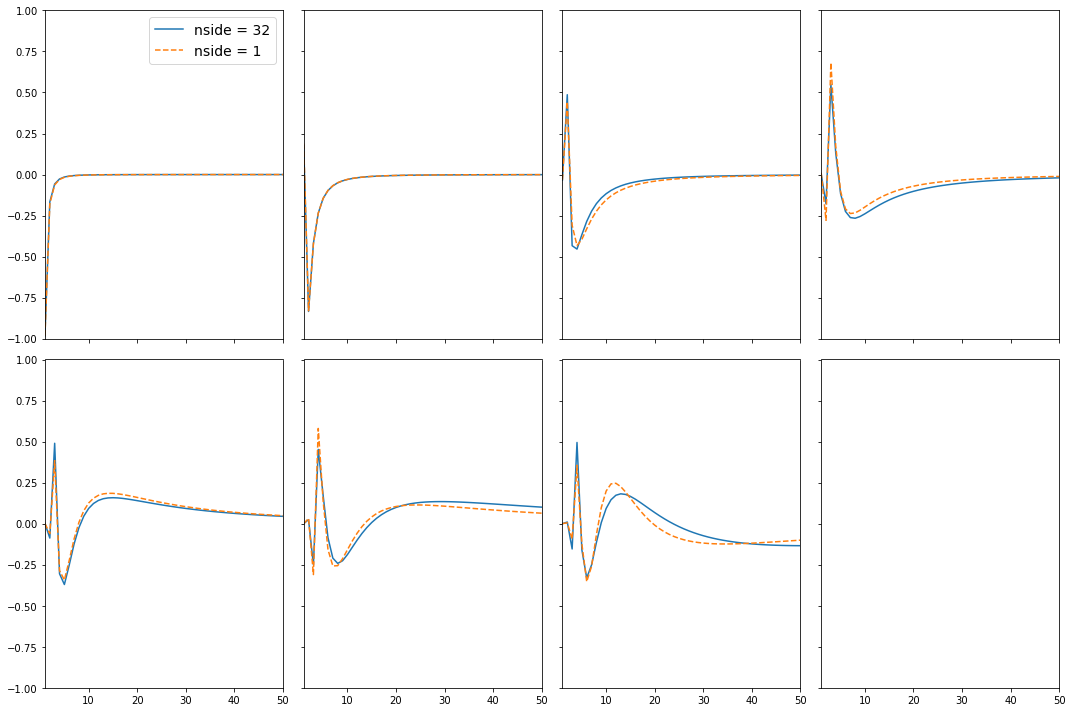

In [69]:
fig, axs = plt.subplots(figsize=(15,10), nrows=2, ncols=4, sharex=True, sharey=True)
for i in range(7):
    ax = axs.ravel()[i]
    ax.plot(ea.freqs, ea.evecs[i], label="nside = 32")
    ax.plot(ea.freqs, ea8.evecs[i], ls="--", label="nside = 1")
axs[0, 0].legend(fontsize=14)
plt.setp(axs, xlim=(ea.freqs.min(), ea.freqs.max()), ylim=(-1,1))
plt.tight_layout()
plt.show()

# MaxSmooth Functions

In [ ]:
freqs = np.linspace(1, 50, 50)
sky = fitsio.read("../simulation/SkyModels/ULSA_32_ddi_smooth.fits")
t21 = T_DarkAges(freqs)
# degrade
nside = 16
npix = 12 * nside ** 2
sky_32 = sky.copy()
sky_16 = np.empty((freqs.size, npix))
for i in range(freqs.size):
    sky_16[i] = hp.ud_grade(sky_32[i], nside)
    
# remove galaxy
b_min = 20  # deg
col_min = np.pi/2 - np.deg2rad(b_min)
col_max = np.pi/2 + np.deg2rad(b_min)
mask_pix = hp.query_strip(nside, col_min, col_max, inclusive=False)
sky_16 = np.delete(sky_16, mask_pix, axis=1)
npix = sky_16.shape[-1]

# fit maxsmooth
N_terms = 5
sky_res = sky_16.copy()
t21_map = np.repeat(t21.reshape(-1, 1), npix, axis=1)
sky_21cm = sky_16 + t21_map
sky_21_res = sky_21cm.copy()

for pix in range(npix):
    result = smooth(freqs, sky_16[:, pix], N_terms, model_type="loglog_polynomial", print_output=False)
    sky_res[:, pix] -= result.y_fit
    
    result_21 = smooth(freqs, sky_21cm[:, pix], N_terms, model_type="loglog_polynomial", print_output=False)
    sky_21_res[:, pix] -= result_21.y_fit
    
fig, axs = plt.subplots(figsize=(10,10), nrows=2, ncols=2, sharex=True)
axs[0, 0].plot(freqs, sky_16[:, -1], label="foregrounds")
axs[0, 0].plot(freqs, result.y_fit, ls="--", label="fit")
axs[0, 0].legend()
axs[0, 0].set_yscale("log")
axs[0, 1].plot(freqs, sky_21cm[:, -1], label="foreground + 21cm")
axs[0, 1].plot(freqs, result_21.y_fit, label="fit")
axs[0, 1].legend()
axs[0, 1].set_yscale("log")
axs[1, 0].plot(freqs, sky_res[:, -1])
axs[1, 1].plot(freqs, sky_21_res[:, -1])
axs[0, 0].set_ylabel("temperature [K]")
axs[1, 0].set_ylabel("residuals [K]")
plt.setp(axs[1], xlabel="frequency [MHz]", xlim=(freqs.min(), freqs.max()))
plt.show()

In [ ]:
freqs = np.linspace(1, 50, 50)
sky = fitsio.read("../simulation/sky_data/ULSA_32_ddi_smooth.fits")
t21 = T_DarkAges(freqs)
    
# remove galaxy
b_min = 20  # deg
col_min = np.pi/2 - np.deg2rad(b_min)
col_max = np.pi/2 + np.deg2rad(b_min)
mask_pix = hp.query_strip(nside, col_min, col_max, inclusive=False)
sky = np.delete(sky, mask_pix, axis=1)
mean_sky = sky.mean(axis=1)

# fit maxsmooth
N_terms = 20

result_fg = smooth(freqs, mean_sky, N_terms, model_type="loglog_polynomial", print_output=False)
result_21 = smooth(freqs, mean_sky + t21, N_terms, model_type="loglog_polynomial", print_output=False)

fg_loglog = result_fg.y_fit
t21_loglog = result_21.y_fit
    
fig, axs = plt.subplots(figsize=(10,10), nrows=2, ncols=2, sharex=True, sharey="row")
axs[0, 0].plot(freqs, mean_sky, label="foregrounds")
axs[0, 0].plot(freqs, fg_loglog, ls="--", label="fit")
axs[0, 0].legend()
axs[0, 0].set_yscale("log")
axs[0, 1].plot(freqs, mean_sky + t21, label="foreground + 21cm")
axs[0, 1].plot(freqs, t21_loglog, ls="--", label="fit")
axs[0, 1].legend()
axs[0, 1].set_yscale("log")
axs[1, 0].plot(freqs, mean_sky - fg_loglog)
axs[1, 1].plot(freqs, mean_sky + t21 - t21_loglog)
axs[0, 0].set_ylabel("temperature [K]")
axs[1, 0].set_ylabel("residuals [K]")
plt.setp(axs[1], xlabel="frequency [MHz]", xlim=(freqs.min(), freqs.max()))
plt.show()

plt.figure()
plt.plot(freqs, mean_sky - fg_loglog, label="foregrounds")
plt.plot(freqs, mean_sky + t21 - t21_loglog, ls="--", label="foregrounds + 21cm")
plt.plot(freqs, t21, label="21cm")
plt.title(f"Residuals after fitting {N_terms} terms")
plt.legend()
plt.show()

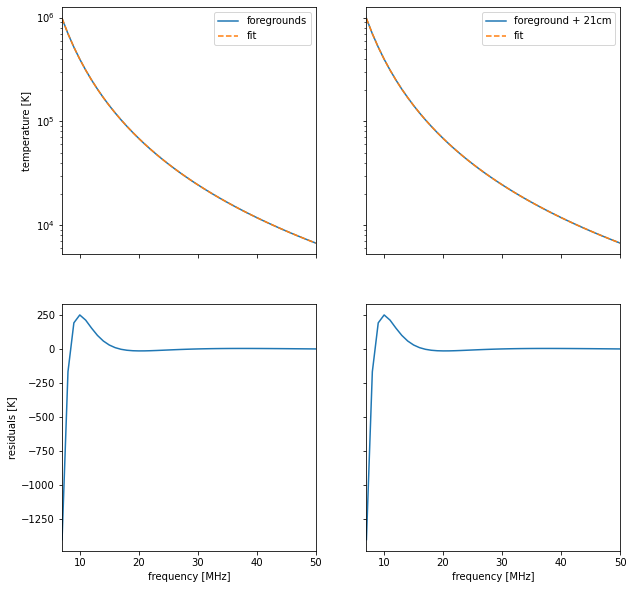

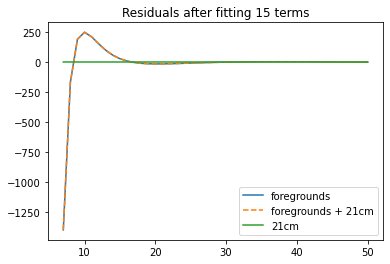

In [291]:
freqs = np.linspace(1, 50, 50)
sky = fitsio.read("../simulation/sky_data/ULSA_32_ddi_smooth.fits")
t21 = T_DarkAges(freqs)
    
# remove galaxy
b_min = 20  # deg
col_min = np.pi/2 - np.deg2rad(b_min)
col_max = np.pi/2 + np.deg2rad(b_min)
mask_pix = hp.query_strip(nside, col_min, col_max, inclusive=False)
sky = np.delete(sky, mask_pix, axis=1)
mean_sky = sky.mean(axis=1)

# fit maxsmooth
N_terms = 15
f_min = 6
mean_sky = mean_sky[freqs > f_min]
t21 = t21[freqs > f_min]
freqs = freqs[freqs > f_min]

result_fg = smooth(freqs, mean_sky, N_terms, model_type="loglog_polynomial", print_output=False)
result_21 = smooth(freqs, mean_sky + t21, N_terms, model_type="loglog_polynomial", print_output=False)

fg_loglog = result_fg.y_fit
t21_loglog = result_21.y_fit
    
fig, axs = plt.subplots(figsize=(10,10), nrows=2, ncols=2, sharex=True, sharey="row")
axs[0, 0].plot(freqs, mean_sky, label="foregrounds")
axs[0, 0].plot(freqs, fg_loglog, ls="--", label="fit")
axs[0, 0].legend()
axs[0, 0].set_yscale("log")
axs[0, 1].plot(freqs, mean_sky + t21, label="foreground + 21cm")
axs[0, 1].plot(freqs, t21_loglog, ls="--", label="fit")
axs[0, 1].legend()
axs[0, 1].set_yscale("log")
axs[1, 0].plot(freqs, mean_sky - fg_loglog)
axs[1, 1].plot(freqs, mean_sky + t21 - t21_loglog)
axs[0, 0].set_ylabel("temperature [K]")
axs[1, 0].set_ylabel("residuals [K]")

plt.setp(axs[1], xlabel="frequency [MHz]", xlim=(freqs.min(), freqs.max()))
plt.show()

plt.figure()
plt.plot(freqs, mean_sky - fg_loglog, label="foregrounds")
plt.plot(freqs, mean_sky + t21 - t21_loglog, ls="--", label="foregrounds + 21cm")
plt.plot(freqs, t21, label="21cm")
plt.title(f"Residuals after fitting {N_terms} terms")
plt.legend()
plt.show()

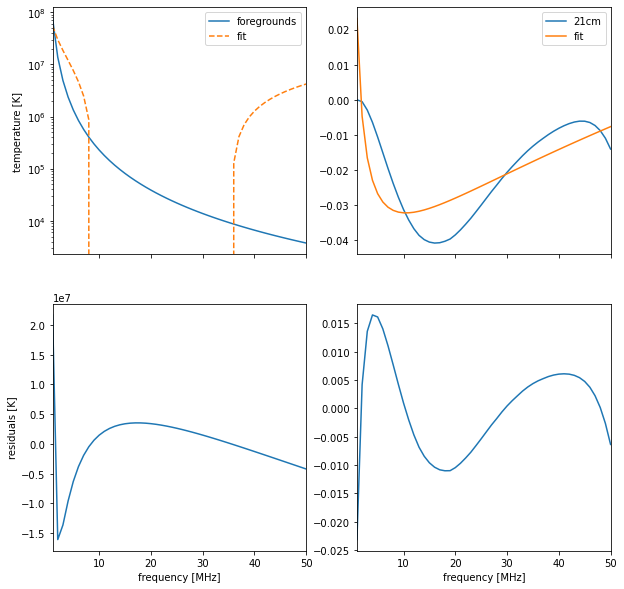

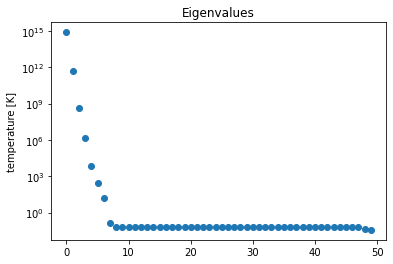

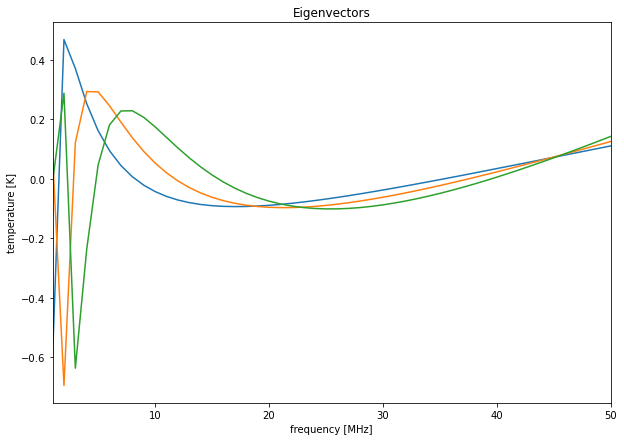

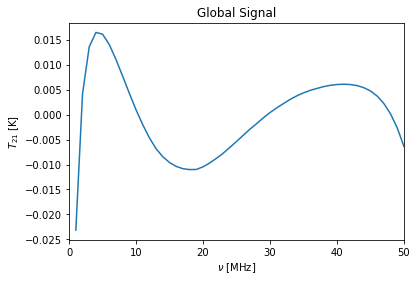

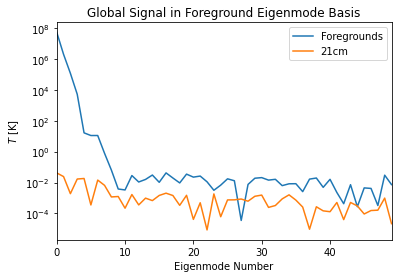

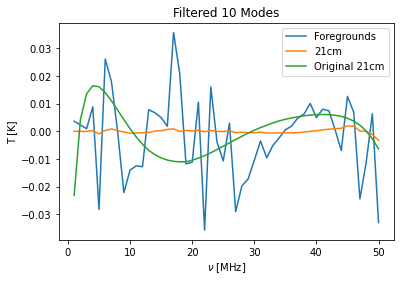

In [292]:
ea = EigenAnalysis()
ea.degrade(nside_out=16)
ea.remove_gal(20)
ea.fit_maxsmooth(N_terms=3, plot=True)
ea.plot_evals()
ea.plot_evecs()
ea.plot_t21()
ea.plot_proj()
ea.plot_filtered(10)